# Portfolio Optimization

Run [this notebook](https://colab.research.google.com/drive/1XFP6f8rD7WmDQIelYbKdxjO1mtLa7WhE?usp=sharing) to output a set of portfolios with optimized cash weightings, risk weightings, efficient frontier, and performance statistics. 

In [ ]:
!pip install yfinance
!pip install PyPortfolioOpt
!pip install bt
!pip install ffn
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 18.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

In [ ]:
import requests
r = requests.get('https://raw.githubusercontent.com/Token-DAO/tokendao/branch1/tokendao/portfolio_optimization.py')
with open('portfolio_optimization.py', 'w') as f:
  f.write(r.text)
import portfolio_optimization as opt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from pypfopt import black_litterman, risk_models, efficient_frontier, objective_functions

Input the tickers you want the optimizer to consider. The optimizer may not select all tickers for inclusion in an optimized portfolio. 

In [ ]:
tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'AVAX-USD', 'FTM-USD']

In [ ]:
benchmark_ticker = 'BTC-USD'

Use the gamma variable below to force the optimizer to include more assets. The higher the gamma, the more equal-weighted the optimized portfolio weightings will be. If gamma equals zero, no adjustments are made. For more information on gamma and L2 regularization, refer to https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#more-on-l2-regularisation. 

In [ ]:
gamma = 1.0

Download price history and compute returns. 

In [ ]:
prices = opt.price_history(tickers)
returns = prices.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


Download asset data such as market cap and other fundamentals. 

In [ ]:
info = opt.get_info(tickers).sort_index()

100%|██████████| 5/5 [00:26<00:00,  5.22s/it]


The optimizer requires a risk model in order to quantify asset and portfolio risk. For more information, refer to https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html. 

Options include: 

*   sample_cov
*   semicovariance
*   exp_cov
*   ledoit_wolf
*   ledoit_wolf_constant_variance
*   ledoit_wolf_single_factor
*   ledoit_wolf_constant_correlation
*   oracle_approximating

In [ ]:
risk_model = 'oracle_approximating'
covariance_matrix = risk_models.risk_matrix(prices, risk_model)

Compute expected asset returns using a Black-Littterman (BL) model. Prior estimate of returns is assumed to be the market-implied expected asset returns. For more information, refer to https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html. 

In [ ]:
market_caps = info['marketCap'].astype(float)
risk_aversion = black_litterman.market_implied_risk_aversion(prices, frequency=365)
expected_returns = black_litterman.market_implied_prior_returns(market_caps, risk_aversion, covariance_matrix)
expected_returns

AVAX-USD    0.376547
BTC-USD     0.501076
ETH-USD     0.654663
FTM-USD     0.455638
SOL-USD     0.554657
dtype: float64

Use this constraints model to assign minimum and maximum weight bounds or create your own. If you don't pass a bounds variable, the optimizer assumes the minimum bounds is 0% and maximum bound is 100%, in other words, "unconstrained".

In [ ]:
bounds = opt.constraints_model(prices)

Compute the minimum risk level. 


In [ ]:
min_volatility = opt.min_risk(expected_returns, covariance_matrix, bounds)

Expected annual return: 52.3%
Annual volatility: 65.0%
Sharpe Ratio: 0.77


Compute the maximum risk level. 

In [ ]:
max_volatility = opt.max_risk(expected_returns, covariance_matrix, bounds)

Expected annual return: 63.0%
Annual volatility: 93.9%
Sharpe Ratio: 0.65


Compute the optimal portfolio. This portfolio has the highest sharpe ratio of all possible portfolios given the assumed expected asset returns, risk model, and constraint bounds. For more information, refer to https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html?highlight=max_sharpe#pypfopt.efficient_frontier.EfficientFrontier.max_sharpe. 

In [ ]:
opt.optimize_portfolio(expected_returns, covariance_matrix, bounds, 'max_sharpe', gamma)[0]

Expected annual return: 57.6%
Annual volatility: 74.2%
Sharpe Ratio: 0.75


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


,1
Ticker,
AVAX-USD,0.0242
BTC-USD,0.4085
ETH-USD,0.4741
FTM-USD,0.0000
SOL-USD,0.0932


Compute the efficient frontier of portfolios along with the expected return, volatility, and sharpe ratio of each portfolio. This particular function will compute 20 efficient frontier portfolios. 

In [ ]:
ef_portfolios, ef_results = opt.compute_efficient_frontier(expected_returns, covariance_matrix, bounds, gamma)

100%|██████████| 20/20 [00:00<00:00, 23.26it/s]


In [ ]:
ef_portfolios # Cash % weightings 

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AVAX-USD,0.1164,0.1210,0.1254,0.1295,0.1335,0.1372,0.1407,0.1441,0.1472,0.1502,0.1525,0.1534,0.1541,0.1547,0.1552,0.1556,0.1558,0.1560,0.1562,0.1562
BTC-USD,0.4408,0.4278,0.4153,0.4035,0.3922,0.3814,0.3710,0.3611,0.3516,0.3422,0.3343,0.3291,0.3242,0.3195,0.3148,0.3104,0.3061,0.3020,0.2979,0.2940
ETH-USD,0.3515,0.3515,0.3512,0.3506,0.3498,0.3487,0.3475,0.3461,0.3446,0.3430,0.3412,0.3393,0.3374,0.3355,0.3336,0.3317,0.3299,0.3281,0.3263,0.3245
FTM-USD,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0012,0.0056,0.0100,0.0144,0.0187,0.0230,0.0273,0.0316,0.0358,0.0400
SOL-USD,0.0914,0.0997,0.1081,0.1163,0.1246,0.1326,0.1408,0.1487,0.1566,0.1646,0.1708,0.1726,0.1744,0.1760,0.1777,0.1793,0.1809,0.1824,0.1839,0.1853


In [ ]:
ef_results # Risk and return

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Expected_Return,0.5455,0.5453,0.5452,0.5450,0.5448,0.5447,0.5445,0.5443,0.5441,0.5439,0.5436,0.5431,0.5426,0.5421,0.5417,0.5412,0.5408,0.5404,0.5400,0.5396
Volatility,0.7385,0.7448,0.7512,0.7575,0.7639,0.7702,0.7766,0.7829,0.7892,0.7956,0.8019,0.8083,0.8146,0.8209,0.8273,0.8336,0.8400,0.8463,0.8527,0.8590
Sharpe_Ratio,0.7115,0.7053,0.6991,0.6931,0.6871,0.6812,0.6753,0.6696,0.6640,0.6585,0.6529,0.6471,0.6415,0.6360,0.6306,0.6253,0.6200,0.6149,0.6098,0.6049


In [ ]:
opt.risk_weightings(ef_portfolios, covariance_matrix) # Risk % weightings

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
AVAX-USD,0.147544,0.153032,0.158102,0.162687,0.166965,0.170834,0.174245,0.177493,0.180238,0.182738,0.184163,0.183417,0.182355,0.181187,0.179893,0.178460,0.176751,0.175044,0.173381,0.171503
BTC-USD,0.336015,0.320865,0.306409,0.292975,0.280129,0.268196,0.256721,0.246004,0.235859,0.225982,0.217569,0.211470,0.205679,0.200188,0.194806,0.189729,0.184807,0.180099,0.175506,0.171162
ETH-USD,0.380485,0.376855,0.372765,0.368428,0.363707,0.358909,0.353866,0.348750,0.343596,0.338323,0.333114,0.328211,0.323330,0.318564,0.313855,0.309192,0.304672,0.300179,0.295770,0.291472
FTM-USD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002517,0.011806,0.021180,0.030629,0.039925,0.049268,0.058652,0.068057,0.077262,0.086494
SOL-USD,0.135955,0.149248,0.162724,0.175911,0.189198,0.202061,0.215168,0.227753,0.240307,0.252957,0.262637,0.265095,0.267455,0.269432,0.271520,0.273352,0.275119,0.276620,0.278082,0.279369


Plot the efficient frontier with individual assets, along with the maximum sharpe and minimum volatility portfolios. 

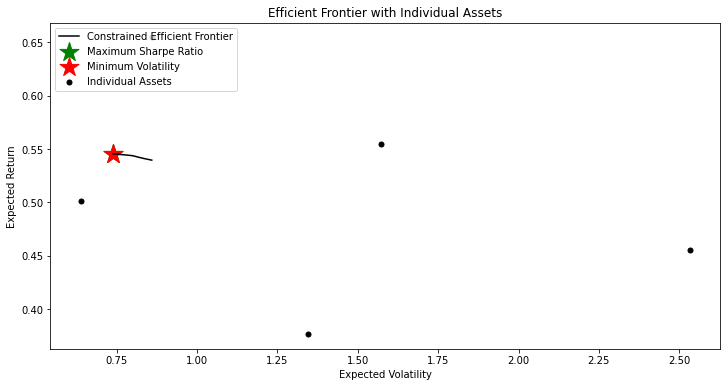

In [ ]:
%matplotlib inline
opt.eff_frontier_plot(covariance_matrix, expected_returns, ef_results, figsize=(12, 6))

Backtest each portfolio and compare to benchmark index. 

In [ ]:
ef_backtests = opt.compile_backtests(ef_portfolios, prices)

In [ ]:
benchmark_backtests = opt.benchmark_backtest(benchmark_ticker)

[*********************100%***********************]  1 of 1 completed


In [ ]:
Results = opt.run_backtest(ef_backtests, benchmark_backtests)

Plot the backtest performance of each portfolio along with benchmark index. 

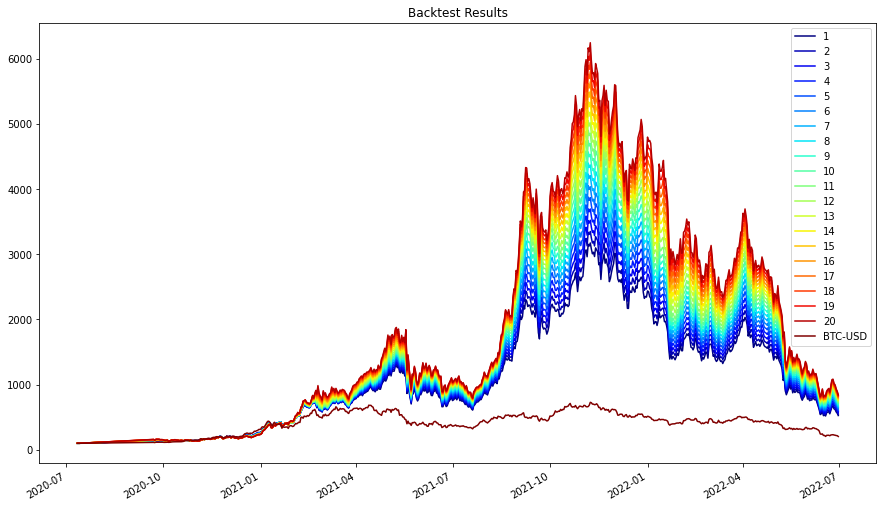

In [ ]:
opt.linechart(Results)

DataFrame of each porfolio's historical value. 

In [ ]:
portfolio_values = opt.backtest_timeseries(Results)

Compute comprehensive risk and return statistics for each portfolio. 

In [ ]:
opt.performance_stats(portfolio_values, benchmark_ticker='BTC-USD', risk_free_rate=0.02, freq=365)

,vol,beta,cagr,drawdown,capm,jensen_alpha,m2,m2_alpha,sharpe,treynor,sortino,info_ratio,capture_ratio,appraisal_ratio,ulcer
07-13-2020 - 06-30-2022,,,,,,,,,,,,,,,
1,1.0002,1.0523,1.5463,-0.8343,0.5226,1.0236,1.1752,0.6776,1.5260,1.4693,2.2669,0.0645,1.0580,1.6926,0.2861
2,1.0120,1.0534,1.6051,-0.8366,0.5231,1.0821,1.2058,0.7081,1.5664,1.5238,2.3330,0.0655,1.0592,1.7366,0.2917
3,1.0235,1.0524,1.6606,-0.8386,0.5227,1.1380,1.2334,0.7358,1.6029,1.5779,2.3944,0.0661,1.0602,1.7710,0.2969
4,1.0345,1.0532,1.7162,-0.8405,0.5230,1.1932,1.2612,0.7636,1.6396,1.6296,2.4567,0.0669,1.0611,1.8099,0.3020
5,1.0453,1.0537,1.7711,-0.8425,0.5233,1.2479,1.2881,0.7905,1.6752,1.6808,2.5188,0.0677,1.0630,1.8471,0.3068
6,1.0555,1.0542,1.8231,-0.8442,0.5235,1.2996,1.3132,0.8155,1.7083,1.7294,2.5746,0.0684,1.0634,1.8812,0.3112
7,1.0657,1.0545,1.8753,-0.8458,0.5237,1.3516,1.3379,0.8403,1.7410,1.7783,2.6319,0.0690,1.0644,1.9146,0.3157
8,1.0753,1.0548,1.9246,-0.8472,0.5238,1.4008,1.3608,0.8632,1.7713,1.8247,2.6851,0.0696,1.0653,1.9451,0.3199
9,1.0847,1.0549,1.9731,-0.8486,0.5238,1.4492,1.3831,0.8854,1.8006,1.8704,2.7365,0.0702,1.0667,1.9743,0.3239
